# White Giant Cooling Model - Vertical Channels

In [62]:
#Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials


import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
from CoolProp.CoolProp import PropsSI

### *Engine setup*

In [63]:
'''Chamber conditions'''
pc = 15e5                   #Chamber pressure (Pa)
mdot = 5.4489               #Mass flow rate (kg/s)
p_amb = 1.01325e5           #Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              #Oxidiser/fuel mass ratio
water_mass_fraction = 0.40  #Fraction of the fuel that is water, by mass

'''Get combustion properties from pypropep'''
ppp.init()
e = ppp.Equilibrium()
ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

#Add propellants by mass fractions (note the mass fractions can add up to more than 1)
e.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])

#Adiabatic combustion using chamber pressure                      
e.set_state(P = pc/1e5, type='HP')                      

gamma = e.properties.Isex   #pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*e.properties.Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = e.properties.T

'''Set up the engine object'''
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

print(f"\nNozzle throat area = {nozzle.At} m^2, nozzle exit area = {nozzle.Ae} m^2")

'''Check the thrust and specific impulse'''
print("")
print(f"Chamber Temperature: {Tc} K")
print(f"Gamma = {gamma}")
print(f"cp = {cp} J/kg/K")
print("")
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN      (using perfect gas relations)")
print(f"Sea level Isp = {engine.isp(1e5)} s         (using perfect gas relations)")

print("\nCombustion product composition:")
print(e.composition_sorted[0:8])

Loaded 1921 thermo species
Loaded 1031 propellants
NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.

Nozzle throat area = 0.006712812133545899 m^2, nozzle exit area = 0.021131183305612325 m^2

Chamber Temperature: 2895.328510803194 K
Gamma = 1.1430282235267117
cp = 3827.3842050453954 J/kg/K

Sea level thrust = 13.752350411700128 kN      (using perfect gas relations)
Sea level Isp = 257.36377399776666 s         (using perfect gas relations)

Combustion product composition:
[('N2', 0.44858189057515907), ('H2O', 0.31544079952923687), ('CO2', 0.10586557591576176), ('CO', 0.06431784187457161), ('H2', 0.026695526870492998), ('OH', 0.017092326169212368), ('O2', 0.008861419076971232), ('NO', 0.006486268952163105)]


### Pure ethanol coolant

In [64]:
'''Transport properties'''
#CoolProp takes mole fractions for mixtures I believe, not mass fractions.
#Setup the exhaust gas transport properties
def Pr_gas(T, p):
    return PropsSI("PRANDTL", "T", T, "P", p, "NITROGEN")

def mu_gas(T, p):
    return PropsSI("VISCOSITY", "T", T, "P", p, "NITROGEN")

def k_gas(T, p):
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "NITROGEN")

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
def Pr_coolant(T, p):
    try:
        return PropsSI("PRANDTL", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("PRANDTL", "T", T, "Q", 0, "ETHANOL")
    
def mu_coolant(T, p):
    try:
        return PropsSI("VISCOSITY", "T", T, "P", p, "ETHANOL")
    except ValueError:
        print(f"COOLANT BOIL-OFF AT T = {T-273.15} C")
        return PropsSI("VISCOSITY", "T", T, "Q", 0, "ETHANOL")

def k_coolant(T, p):
    try:
        return PropsSI("CONDUCTIVITY", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("CONDUCTIVITY", "T", T, "Q", 0, "ETHANOL")
    
def cp_coolant(T, p):
    try:
        return PropsSI("CPMASS", "T", T, "P", p, "ETHANOL")
    except ValueError:
        return PropsSI("CPMASS", "T", T, "Q", 0, "ETHANOL")
    
def rho_coolant(T, p):
    try:
        return PropsSI("DMASS", "T", T, "P", p, "ETHANOL") 
    except ValueError:
        return PropsSI("DMASS", "T", T, "Q", 0, "ETHANOL")
    
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'ETHANOL')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'ETHANOL')

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant,
                                                    T_from_enthalpy = T_from_enthalpy,
                                                    enthalpy_from_T = enthalpy_from_T)



#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

In [65]:
'''Chamber and wall geometry'''
Ac = np.pi*0.1**2                      #Chamber cross-sectional area (m^2)
inner_wall_thickness = 2e-3            #Thickness of the metal engine liner (m)
L_star = 1.2                           #L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac   #Length of the combustion chamber
engine.add_geometry(chamber_length = chamber_length,
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness,
                   outer_wall_thickness = 3e-3)

'''Coolant jacket'''
mdot_coolant = mdot/(OF_ratio + 1)               #Coolant mass flow rate
inlet_T = 298.15                                 #Coolant inlet temperature
inlet_p0 = 50e5                                  #Tank / inlet coolant stagnation pressure (Pa)
inner_wall_material = bam.materials.CopperC700         #Copper inner wall
outer_wall_material = bam.materials.StainlessSteel304
channel_height = 3e-3
blockage_ratio = 0.5
number_of_ribs = 200

#Add the cooling jacket
engine.add_cooling_jacket(inner_wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "vertical", 
                               channel_height = channel_height,
                               blockage_ratio = blockage_ratio,
                               number_of_ribs = number_of_ribs,
                         outer_wall_material = outer_wall_material)


'''Graphite insert'''
ablative_material = bam.materials.Graphite
engine.add_ablative(ablative_material)

#Run simulation
ethanol_coolant_heating_data = engine.steady_heating_analysis(to_json = False, 
                                              h_gas_model = 'bartz-sigma', 
                                              h_coolant_model = 'gnielinski',
                                              gas_fudge_factor = 1.3)

### Dodgy weighted average of water and ethanol properties

In [66]:
def Pr_coolant(T, p):
    return (water_mass_fraction*PropsSI("PRANDTL", "T", T, "P", p, "WATER") 
            + (1-water_mass_fraction)*water_mass_fraction*PropsSI("PRANDTL", "T", T, "P", p, "ETHANOL"))

def mu_coolant(T, p):
    return (water_mass_fraction*PropsSI("VISCOSITY", "T", T, "P", p, "WATER")
            + (1-water_mass_fraction)*PropsSI("VISCOSITY", "T", T, "P", p, "ETHANOL"))

def k_coolant(T, p):
    return (water_mass_fraction*PropsSI("CONDUCTIVITY", "T", T, "P", p, "WATER")
            + (1-water_mass_fraction)*PropsSI("CONDUCTIVITY", "T", T, "P", p, "ETHANOL"))

def cp_coolant(T, p):
    return (water_mass_fraction*PropsSI("CPMASS", "T", T, "P", p, "WATER")
            + (1-water_mass_fraction)*PropsSI("CPMASS", "T", T, "P", p, "ETHANOL"))

def rho_coolant(T, p):
    return (water_mass_fraction*PropsSI("DMASS", "T", T, "P", p, "WATER")
            + (1-water_mass_fraction)*PropsSI("DMASS", "T", T, "P", p, "ETHANOL"))

'''
def T_from_enthalpy(enthalpy, p):
    return PropsSI('T','H', enthalpy,'P', p, 'WATER')

def enthalpy_from_T(T, p):
    return PropsSI('H','T', T, 'P', p, 'WATER')
'''

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

engine.add_cooling_jacket(inner_wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "vertical", 
                               channel_height = channel_height,
                               blockage_ratio = blockage_ratio,
                               number_of_ribs = number_of_ribs,
                         outer_wall_material = outer_wall_material)

mixed_coolant_heating_data = engine.steady_heating_analysis(to_json = False, 
                                              h_gas_model = 'bartz-sigma', 
                                              h_coolant_model = 'gnielinski',
                                              gas_fudge_factor = 1.3)

NOTE: No enthalpy data provided for the coolant - will use specific heat capacity to predict temperature rises.


## Plot everything

Wall material properties:
bamboo.cooling.Material Object
        Young's modulus = 140.0 GPa 
        0.2% Yield Stress = 600.0 MPa 
        Poisson's ratio = 0.355
        alpha = 1.75e-05 strain/K
        Thermal conductivity = 211 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))

Graphite insert properties:
bamboo.cooling.Material Object
        Young's modulus = nan GPa 
        0.2% Yield Stress = nan MPa 
        Poisson's ratio = nan
        alpha = nan strain/K
        Thermal conductivity = 63.81001 W/m/K
        (may also have a specific heat capacity (self.c) and density (self.rho))



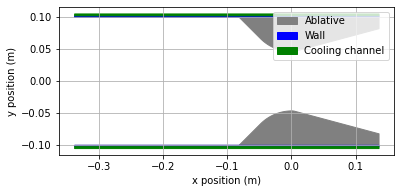

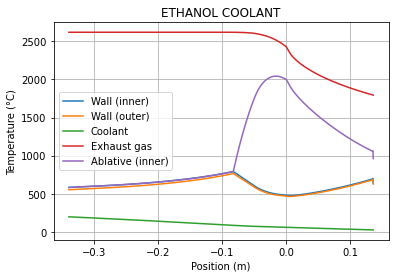

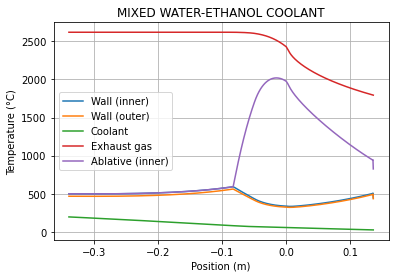

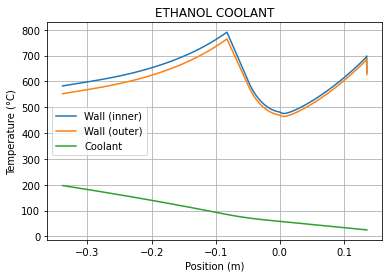

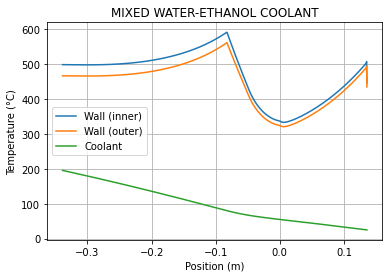

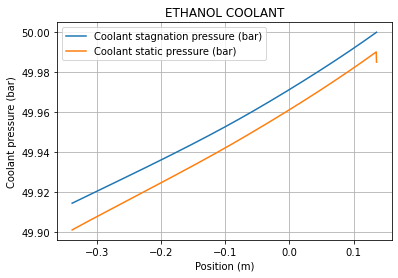

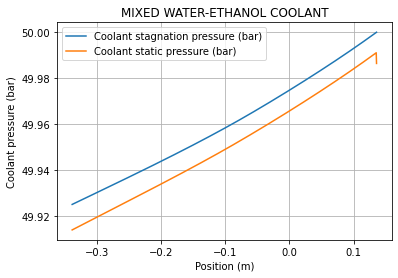

In [67]:
#Print the wall and ablative material properties
print("Wall material properties:")
print(inner_wall_material)

print("\nGraphite insert properties:")
print(ablative_material)
print("")

#Plot the geometry
engine.plot_geometry()
plt.show()

#Show plots
bam.plot.plot_temperatures(ethanol_coolant_heating_data, show_gas = True, show_ablative = True)
plt.title("ETHANOL COOLANT")
plt.show()

bam.plot.plot_temperatures(mixed_coolant_heating_data, show_gas = True, show_ablative = True)
plt.title("MIXED WATER-ETHANOL COOLANT")
plt.show()

bam.plot.plot_temperatures(ethanol_coolant_heating_data, show_gas = False, show_ablative = False)
plt.title("ETHANOL COOLANT")
plt.show()

bam.plot.plot_temperatures(mixed_coolant_heating_data, show_gas = False, show_ablative = False)
plt.title("MIXED WATER-ETHANOL COOLANT")
plt.show()

bam.plot.plot_jacket_pressure(ethanol_coolant_heating_data)
plt.title("ETHANOL COOLANT")
plt.show()

bam.plot.plot_jacket_pressure(mixed_coolant_heating_data)
plt.title("MIXED WATER-ETHANOL COOLANT")
plt.show()

plt.show()

In [68]:
'''
bam.plot.plot_h(heating_data)
plt.title("Convective Heat Transfer Coefficients")

bam.plot.plot_qdot(heating_data)
plt.title("Heat Transfer Rates (per axial unit length)")

bam.plot.plot_resistances(heating_data)
plt.title("Thermal Resistances (per axial unit length)")

bam.plot.plot_exhaust_properties(heating_data)
plt.title("")

bam.plot.plot_coolant_properties(heating_data)
'''

'\nbam.plot.plot_h(heating_data)\nplt.title("Convective Heat Transfer Coefficients")\n\nbam.plot.plot_qdot(heating_data)\nplt.title("Heat Transfer Rates (per axial unit length)")\n\nbam.plot.plot_resistances(heating_data)\nplt.title("Thermal Resistances (per axial unit length)")\n\nbam.plot.plot_exhaust_properties(heating_data)\nplt.title("")\n\nbam.plot.plot_coolant_properties(heating_data)\n'

## Stress analysis

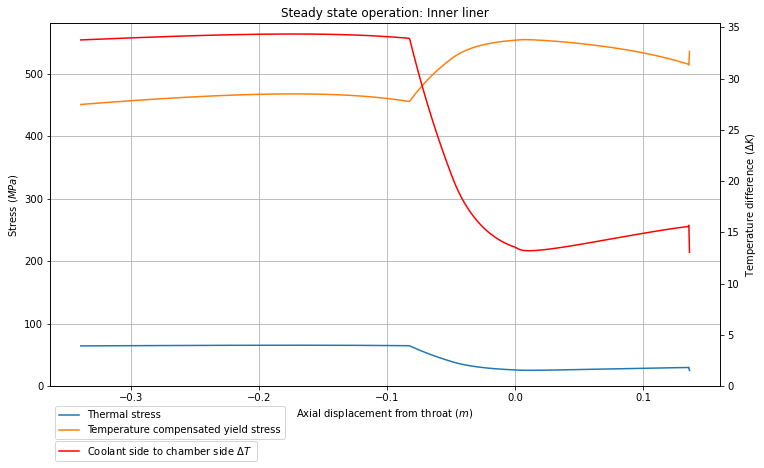

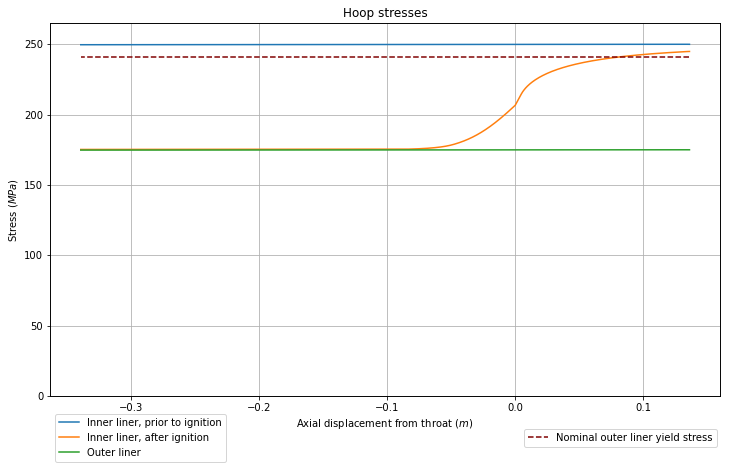

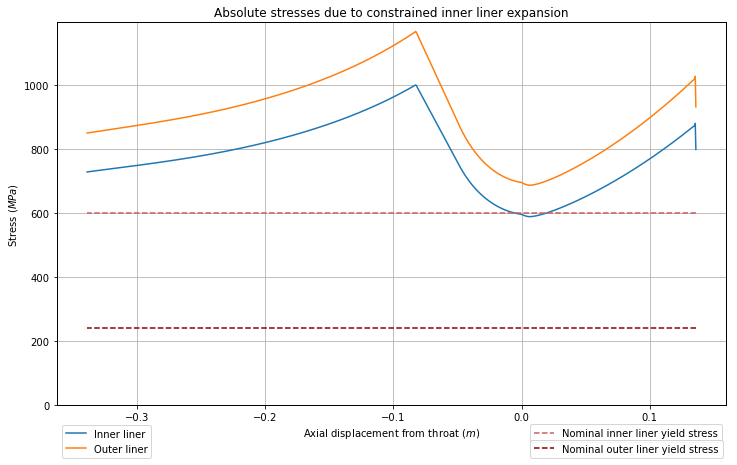

In [69]:
#Steady state stress analysis
steady_stress = engine.run_stress_analysis(heating_result = mixed_coolant_heating_data, condition = "steady")

#Transient stress analysis
transient_stress = engine.run_stress_analysis(heating_result = mixed_coolant_heating_data, condition= "transient", T_amb = inlet_T)

#Graph results - copied from Henry Free's stress_example.py
xs = ethanol_coolant_heating_data["x"]
threshold = 0.5

#If a hoop or inner expansion stress exceeds this proportion of nominal yield stress,
#then show the nominal yield stress on the plot to make it clear this could be problematic
fig1, axs1 = plt.subplots(figsize=(12, 7))
fig2, axs2 = plt.subplots(figsize=(12, 7))
fig3, axs3 = plt.subplots(figsize=(12, 7))

axs1.plot(xs, steady_stress["thermal_stress"]/1E6, label = "Thermal stress")
axs1.plot(xs, steady_stress["yield_adj"]/1E6, label = "Temperature compensated yield stress")
axs1.set_title("Steady state operation: Inner liner")
axs1.set_xlabel("Axial displacement from throat $(m)$")
axs1.set_ylabel("Stress $(MPa)$")
axs1.set_ylim([0, None])
axs1.legend(bbox_to_anchor = (0, -0.16), loc = "lower left")

axs1_2 = axs1.twinx()
axs1_2.plot(xs, steady_stress["deltaT_wall"], color = "red", label = "Coolant side to chamber side $\Delta T$")
axs1_2.set_ylabel("Temperature difference ($\Delta K$)")
axs1_2.set_ylim([0, None])
axs1_2.legend(bbox_to_anchor = (0, -0.22), loc = "lower left")

fig1.subplots_adjust(bottom = 0.16)

axs2.plot(xs, steady_stress["stress_inner_hoop_steady"]/1E6, label = "Inner liner, prior to ignition")
axs2.plot(xs, transient_stress["stress_inner_hoop_transient"]/1E6, label = "Inner liner, after ignition")
axs2.plot(xs, steady_stress["stress_outer_hoop"]/1E6, label = "Outer liner")
ymax2 = axs2.get_ylim()[1]

if np.max(steady_stress["stress_inner_hoop_steady"]) > threshold*inner_wall_material.sigma_y or \
   np.max(transient_stress["stress_inner_hoop_transient"]) > threshold*inner_wall_material.sigma_y:
    axs2i = axs2.twinx()
    axs2i.get_yaxis().set_visible(False)
    axs2i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax2 = max((ymax2, 1.1*inner_wall_material.sigma_y/1E6))
    axs2i.set_ylim(0, ymax2)
    axs2i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(steady_stress["stress_outer_hoop"]) > threshold*outer_wall_material.sigma_y:
    axs2o = axs2.twinx()
    axs2o.get_yaxis().set_visible(False)
    axs2o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax2 = max((ymax2, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs2i.set_ylim(0, ymax2)
    except NameError:
        pass
    axs2o.set_ylim(0, ymax2)
    axs2o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs2.set_title("Hoop stresses")
axs2.set_xlabel("Axial displacement from throat $(m)$")
axs2.set_ylabel("Stress $(MPa)$")
axs2.legend(bbox_to_anchor = (0, -0.19), loc = "lower left")
axs2.set_ylim([0, ymax2])

fig2.subplots_adjust(bottom = 0.14)

axs3.plot(xs, np.abs(transient_stress["stress_inner_IE"]/1E6), label = "Inner liner")
axs3.plot(xs, np.abs(transient_stress["stress_outer_IE"]/1E6), label = "Outer liner")
ymax3 = axs3.get_ylim()[1]

if np.max(np.abs(transient_stress["stress_inner_IE"])) > threshold*inner_wall_material.sigma_y:
    axs3i = axs3.twinx()
    axs3i.get_yaxis().set_visible(False)
    axs3i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax3 = max((ymax3, 1.1*inner_wall_material.sigma_y/1E6))
    axs3i.set_ylim(0, ymax3)
    axs3i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(np.abs(transient_stress["stress_outer_IE"])) > threshold*outer_wall_material.sigma_y:
    axs3o = axs3.twinx()
    axs3o.get_yaxis().set_visible(False)
    axs3o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax3 = max((ymax3, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs3i.set_ylim(0, ymax3)
    except NameError:
        pass
    axs3o.set_ylim(0, ymax3)
    axs3o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs3.set_title("Absolute stresses due to constrained inner liner expansion")
axs3.set_xlabel("Axial displacement from throat $(m)$")
axs3.set_ylabel("Stress $(MPa)$")
axs3.legend(bbox_to_anchor = (0, -0.15), loc = "lower left")
axs3.set_ylim([0, ymax3])

fig3.subplots_adjust(bottom = 0.12)

axs1.grid()
axs2.grid()
axs3.grid()
plt.show()
